In [90]:

%load_ext autoreload
%autoreload 2

In [91]:
import numpy as np 
import matplotlib.pyplot as plt
from skimage import io, transform
from scipy.fft import fft2, ifft2, fftshift, ifftshift
import pywt


(400, 400)

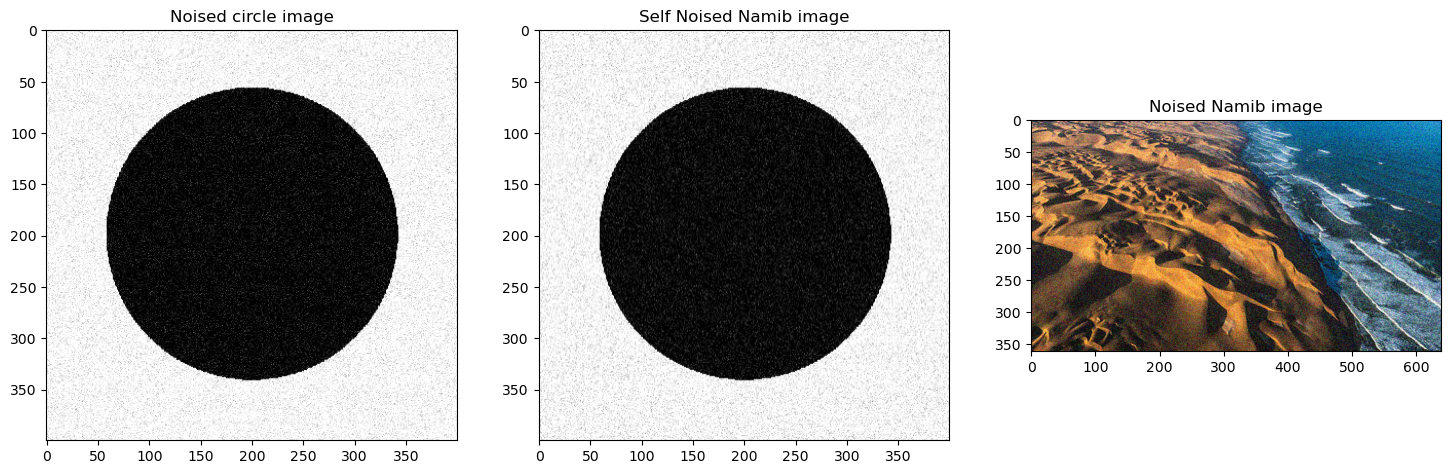

In [ ]:
noised_namib = io.imread("namib-noised.png")
noised_circle = io.imread("circle-noised.png")
circle = io.imread("circle.png")
noise = 30*np.random.randn(*circle.shape)
self_noised_circle = np.clip(circle + noise, 0, 255).astype('uint8')
self_noised_circle = transform.resize(self_noised_circle, output_shape=(400,400))

plt.figure(figsize=(18,6))

plt.subplot(1,3,1)
plt.imshow(noised_circle, cmap='gray')
plt.title("Noised circle image")
plt.subplot(1,3,3)
plt.imshow(noised_namib)
plt.title("Noised Namib image")
plt.subplot(1,3,2)
plt.imshow(self_noised_circle, cmap='gray')
plt.title("Self Noised Namib image")
self_noised_circle.shape


In [183]:
def denoise_image_squares_in_corners(image, keep_fraction):
    plt.figure(figsize=(15, 12))

    plt.subplot(2, 2, 1)
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.title("Noisy Image")

    img_to_freq = fft2(image)
    
    F = np.log(np.abs(img_to_freq) + 1)
    plt.subplot(2, 2, 2)
    plt.imshow(F)
    plt.title("FFT (Log Scale)")

    rows, cols = img_to_freq.shape
    img_to_freq[int(rows * keep_fraction):int(rows * (1 - keep_fraction))] = 0
    img_to_freq[:, int(cols * keep_fraction):int(cols * (1 - keep_fraction))] = 0

    img_to_freq_filtered = img_to_freq
    F_filtered = np.log(np.abs(img_to_freq_filtered) + 1)

    plt.subplot(2, 2, 4)
    plt.imshow(F_filtered)
    plt.title("Filtered FFT (Log Scale)")

    freq_to_img = ifft2(img_to_freq_filtered)
    denoised_image = np.clip(freq_to_img.real, 0, 255)

    plt.subplot(2, 2, 3)
    plt.imshow(denoised_image, cmap='gray')
    plt.axis('off')
    plt.title("Denoised Image")

   

### Obraz pobrany z maila

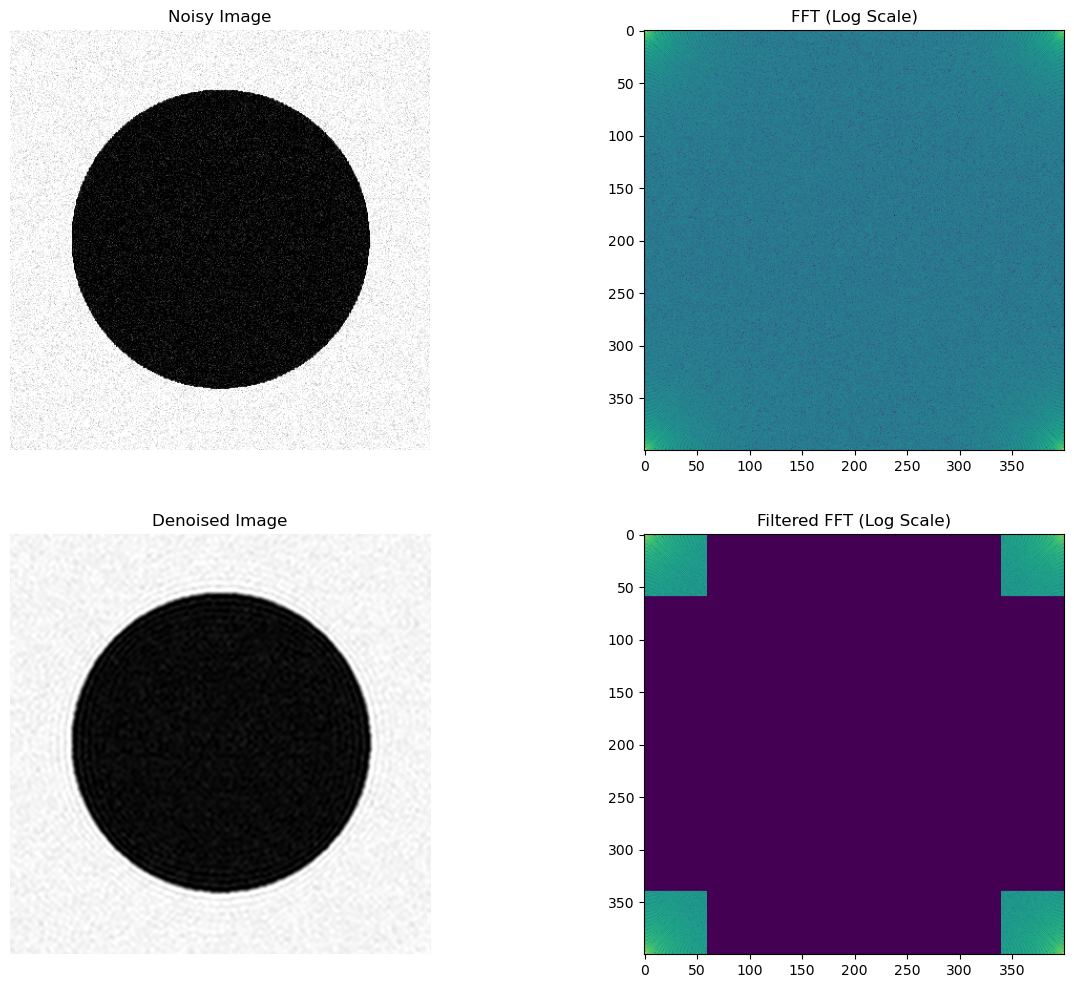

In [184]:
denoise_image_squares_in_corners(noised_circle, 0.15)

### Obraz zaszumiony samodzielnie 

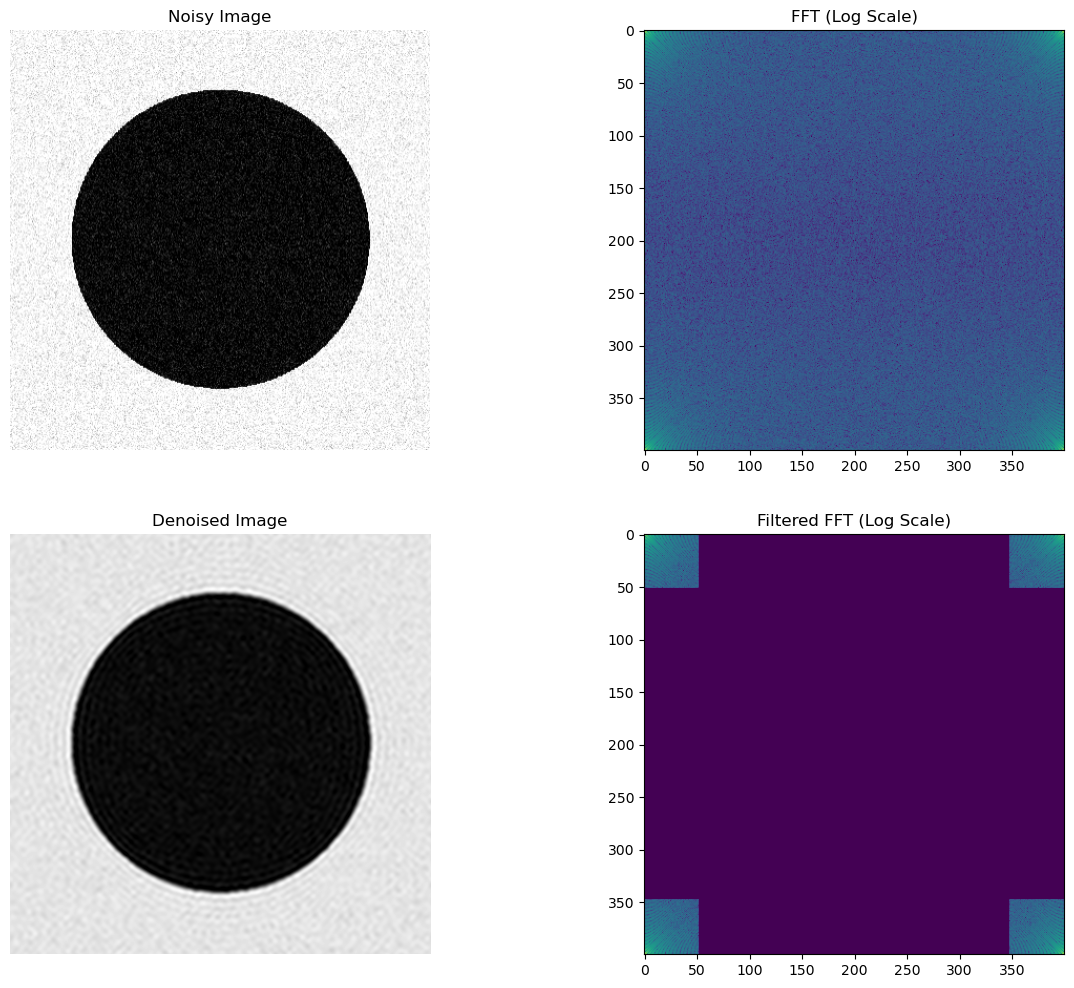

In [185]:
denoise_image_squares_in_corners(self_noised_circle, 0.13)

In [122]:
def denoise_image_radious_filter(image, filter_size):
    plt.figure(figsize=(15, 12))
    plt.subplot(2, 2, 1)
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.title("Noisy Image")

    img_to_freq = fft2(image)
    shift_const_to_center = fftshift(img_to_freq)

    F = np.log(np.abs(shift_const_to_center) + 1)
    
    plt.subplot(2, 2, 2)
    plt.imshow(F)
    plt.title("FFT (Log Scale)")

    # Creating a low-pass filter 
    rows, cols = image.shape
    crow, ccol = rows//2, cols//2
    
    radius = filter_size
    mask = np.zeros((rows, cols), dtype=np.uint8)
    
    y, x = np.ogrid[:rows, :cols]
    distance_from_center = np.sqrt((x - ccol)**2 + (y - crow)**2)
    mask[distance_from_center <= radius] = 1

    
    shifted_freq_filtered = shift_const_to_center * mask

    F_filtered = np.log(np.abs(shifted_freq_filtered) + 1)
    plt.subplot(2, 2, 4)
    plt.imshow(F_filtered)
    plt.title("Filtered FFT (Log Scale)")

    
    freq_shift_back_to_ori_pos = ifftshift(shifted_freq_filtered)
    freq_to_img = ifft2(freq_shift_back_to_ori_pos)
    denoised_image = np.abs(freq_to_img)

    
    plt.subplot(2, 2, 3)
    plt.imshow(denoised_image, cmap='gray')
    plt.axis('off')
    plt.title("Denoised Image")
    



### Obraz pobrany z maila

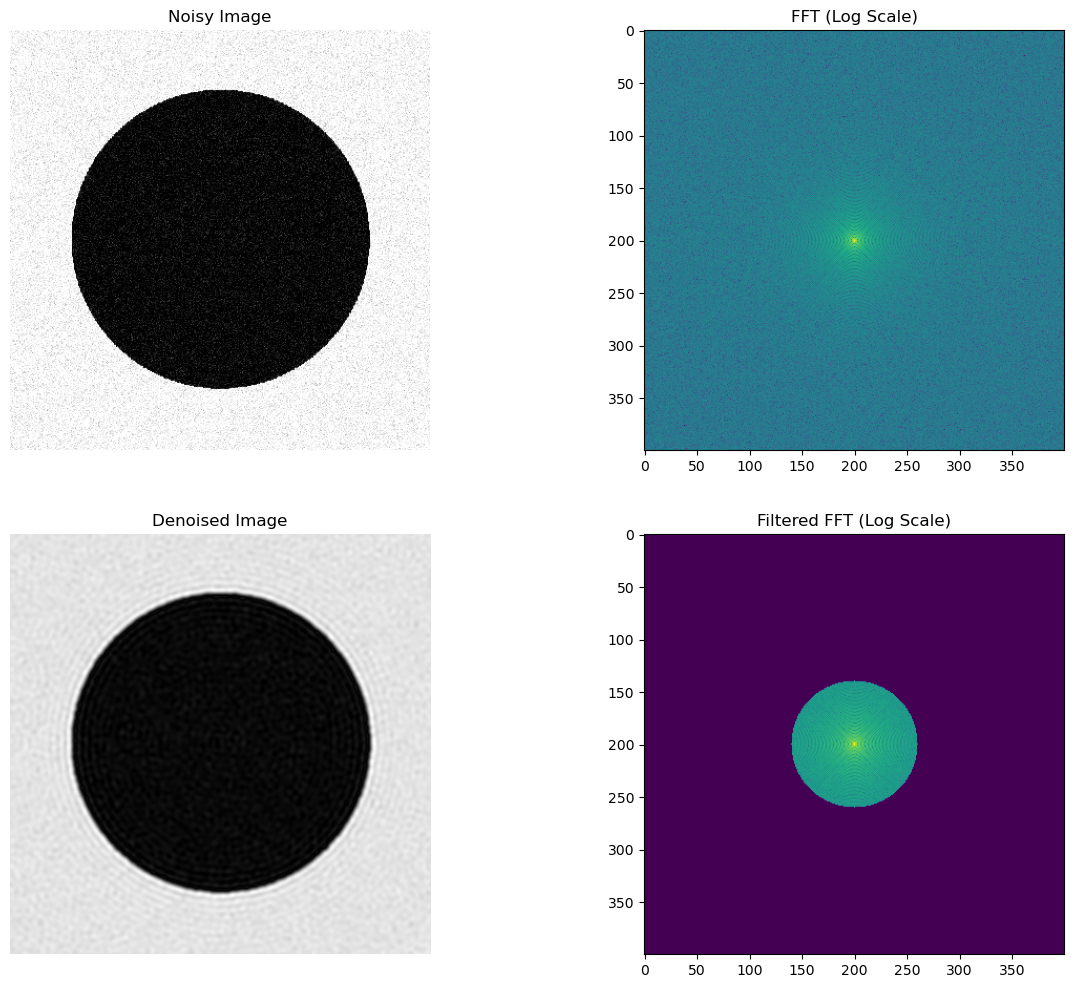

In [123]:
denoise_image_radious_filter(noised_circle, 60)

### Obraz zaszumiony samodzielnie 

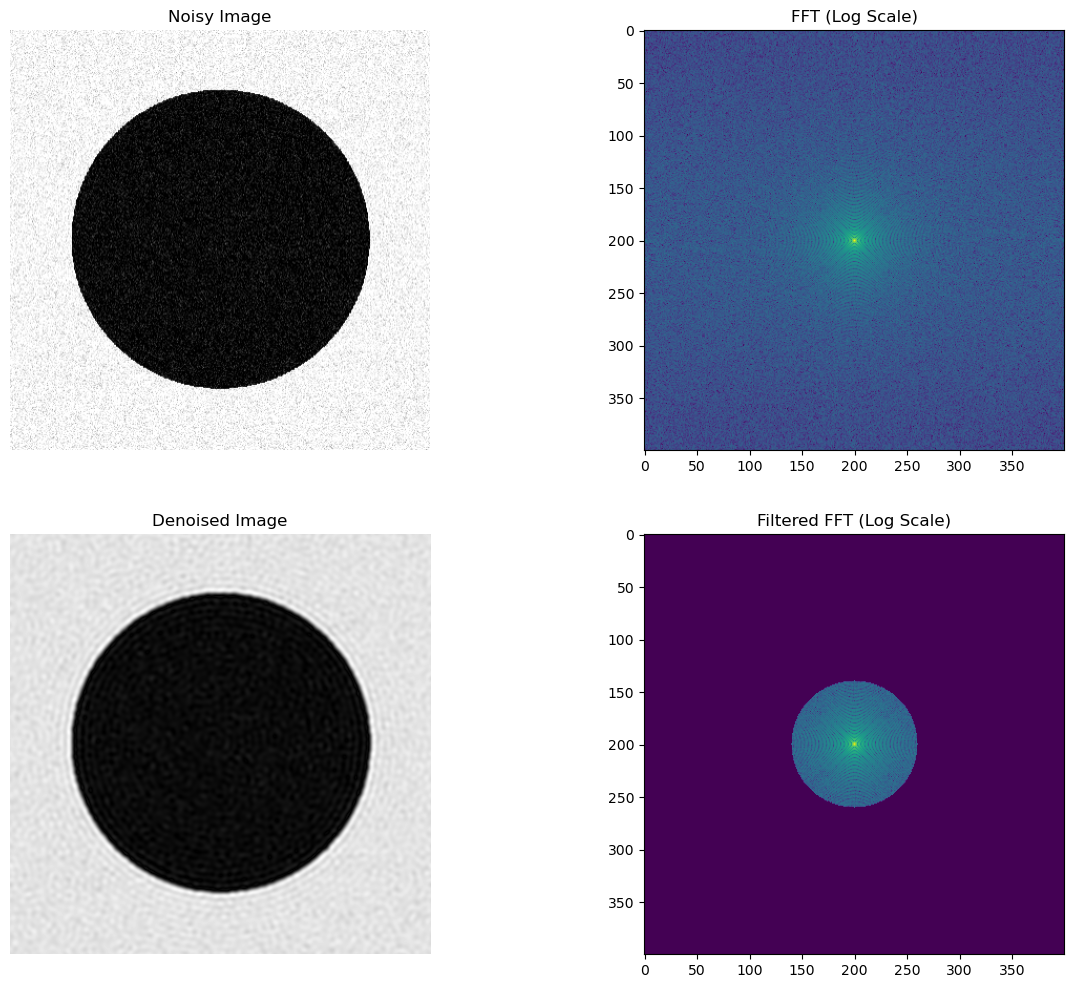

In [128]:
denoise_image_radious_filter(self_noised_circle, 60)

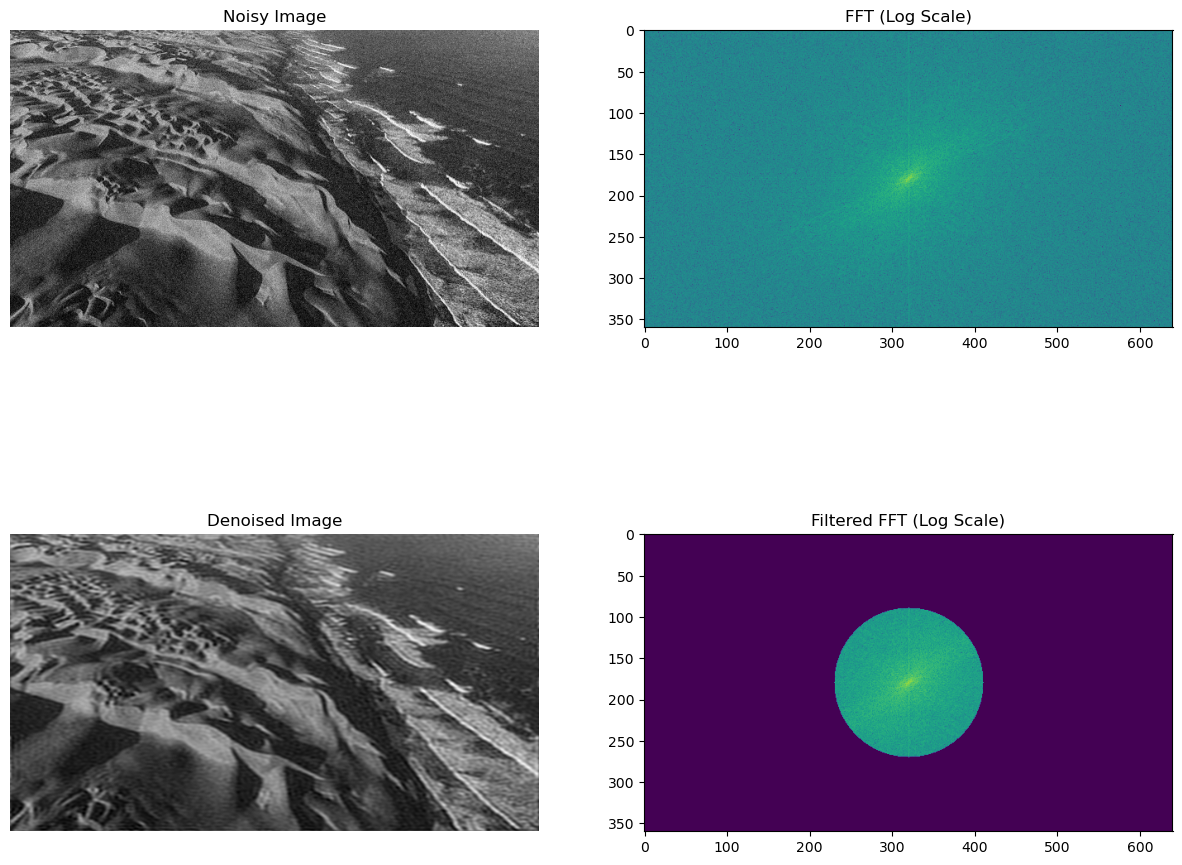

In [124]:
namib = np.mean(noised_namib, -1)
denoise_image_radious_filter(namib, 90)

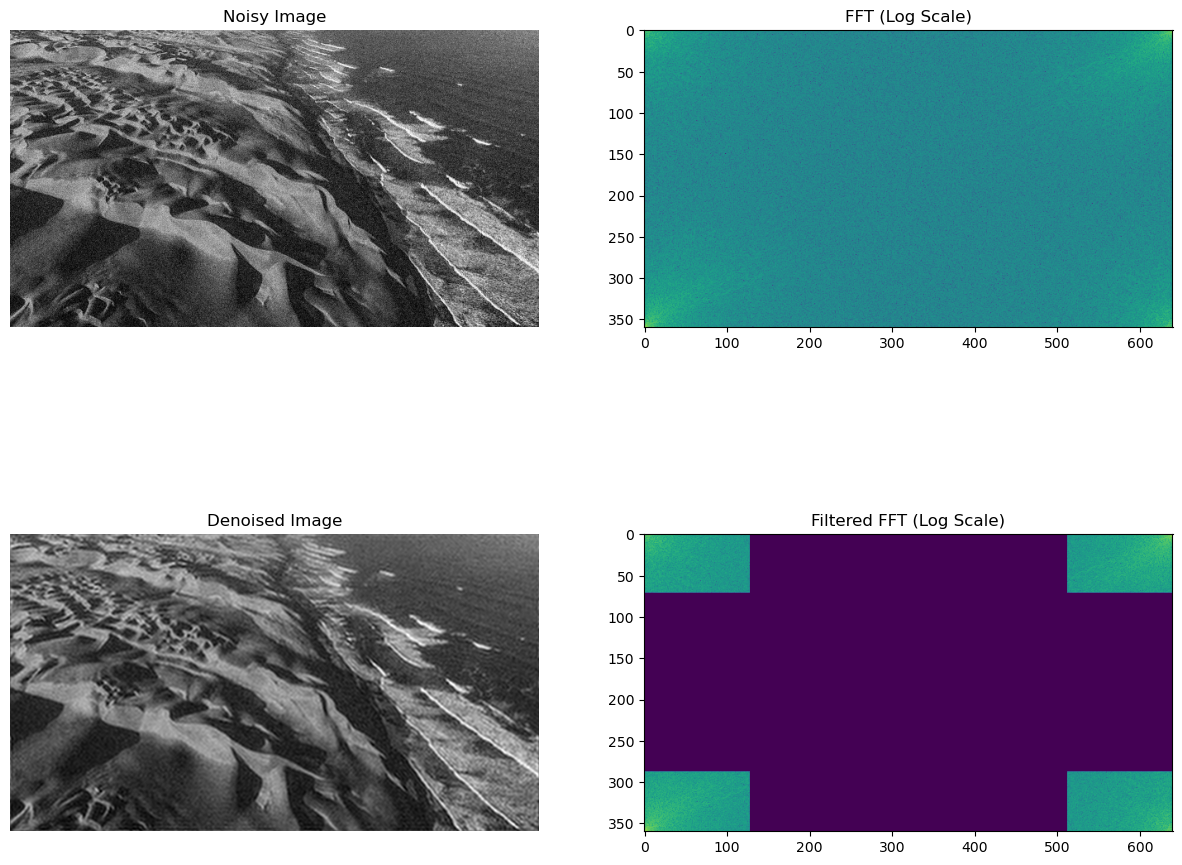

In [186]:
namib = np.mean(noised_namib, -1)
denoise_image_squares_in_corners(namib, 0.2)

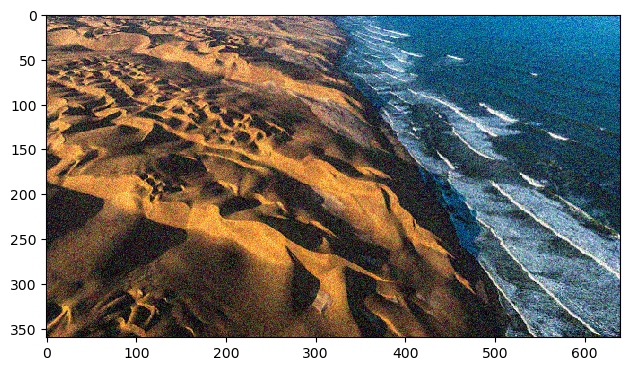

In [13]:
noised_namib = io.imread("namib-noised.png")
io.imshow(noised_namib)

### Implementacja z filtrem w postaci okręgu ucinającym częstotliwości znajdujące się poza środkiem scentralizowanego spektrogramu

In [178]:
def denoise_rgb_image_radious_filter(image, filter_size):
    
    if len(image.shape) != 3 or image.shape[2] != 3:
        raise ValueError("The input image must be a 3-channel RGB image.")

    denoised_image = np.zeros_like(image)
    filtered_freq_visualization = np.zeros_like(image, dtype=np.float32)
    
    for i in range(3):
        channel = image[:, :, i]

        channel_to_freq = fft2(channel)
        shift_const_to_center = fftshift(channel_to_freq)

        rows, cols = channel.shape
        crow, ccol = rows // 2, cols // 2
        radius = filter_size
        mask = np.zeros((rows, cols), dtype=np.uint8)

        y, x = np.ogrid[:rows, :cols]
        distance_from_center = np.sqrt((x - ccol) ** 2 + (y - crow) ** 2)
        mask[distance_from_center <= radius] = 1

        shifted_channel_freq_filtered = shift_const_to_center * mask

        freq_shift_back_to_ori_pos = ifftshift(shifted_channel_freq_filtered)
        freq_to_img = ifft2(freq_shift_back_to_ori_pos)
        denoised_channel = np.abs(freq_to_img)

        
        denoised_image[:, :, i] = denoised_channel
        filtered_freq_visualization[:, :, i] = np.log(np.abs(shifted_channel_freq_filtered) + 1)
        
    
    plt.figure(figsize=(15, 9))

    plt.subplot(1, 2, 1)
    plt.imshow(denoised_image )
    plt.axis('off')
    plt.title('Denoised Image')

    plt.subplot(1, 2, 2)
    plt.imshow(np.sum(filtered_freq_visualization, axis=2))
    plt.title("Filtered FFT Freq Log Scale")
    

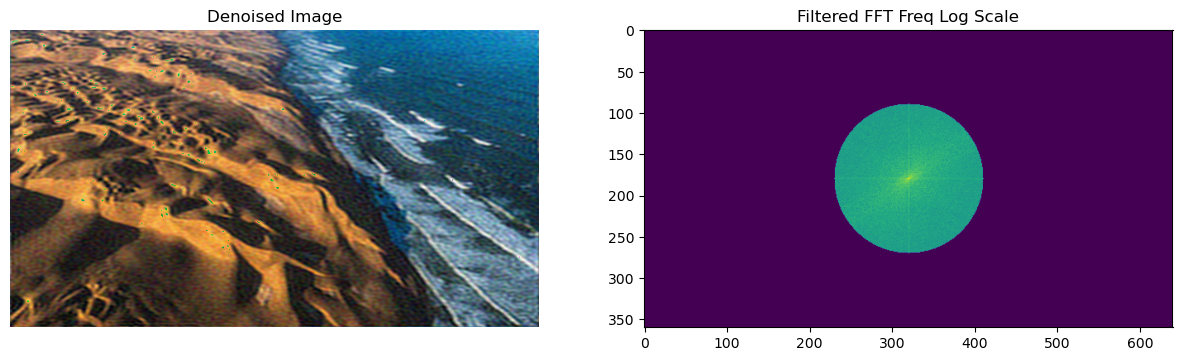

In [179]:
denoise_rgb_image_radious_filter(noised_namib, 90)

### Implementacja usuwająca wirsze oraz kolumny od środka spektrogramu częstotliwości

In [174]:

def denoise_rgb_image_square_filter(image, keep_fraction):
    if len(image.shape) != 3 or image.shape[2] != 3:
        raise ValueError("The input image must be a 3-channel RGB image.")

    denoised_image = np.zeros_like(image)
    filtered_freq_visualization = np.zeros_like(image, dtype=np.float32)

    for i in range(3):
        channel = image[:, :, i]

        channel_freq = fft2(channel)

        rows, cols = channel.shape
        channel_freq[int(rows*keep_fraction):int(rows*(1-keep_fraction))] = 0
        channel_freq[:, int(cols*keep_fraction):int(cols*(1-keep_fraction))] = 0
        channel_freq_filtered =channel_freq
        
        channel_freq_to_img = ifft2(channel_freq_filtered)
        denoised_channel = np.abs(channel_freq_to_img)

        denoised_image[:, :, i] = denoised_channel

        filtered_freq_visualization[:, :, i] = np.log(np.abs(channel_freq_filtered) + 1)
    
    plt.figure(figsize=(15, 9))

    plt.subplot(1, 2, 1)
    plt.imshow(denoised_image )
    plt.axis('off')
    plt.title('Denoised Image')

    plt.subplot(1, 2, 2)
    plt.imshow(np.sum(filtered_freq_visualization, axis=2))
    plt.title("Filtered FFT Freq Log Scale")
    


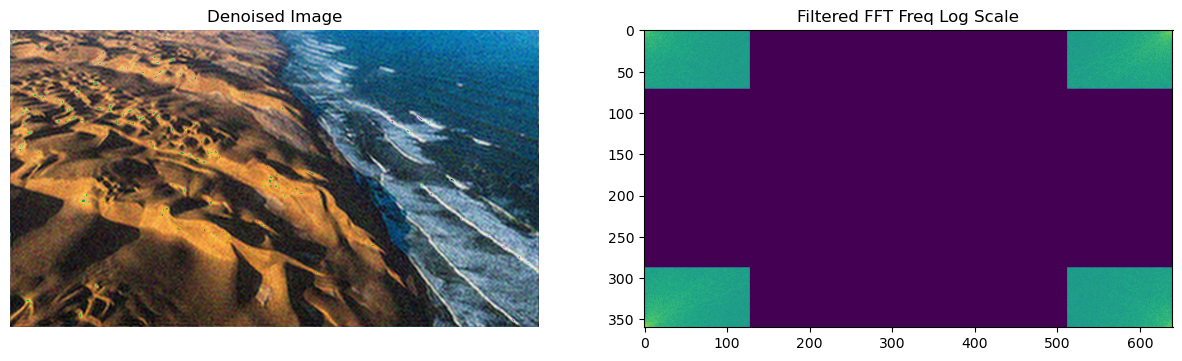

In [175]:
denoise_rgb_image_square_filter(noised_namib, 0.2)

In [23]:
def wdenoise2_py(image, wavelet="coif5", level=None, mode="soft", sigma=None):
    """
    Falkowe odszumianie obrazu 2D wzorowane na MATLAB `wdenoise2`.

    Parameters:
        image (ndarray): Obraz wejściowy 2D.
        wavelet (str): Nazwa falki.
        level (int): Poziom dekompozycji. Jeśli None, zostaje obliczony przy użyciu metody dwt_max_level.
        mode (str): Tryb progowania ('soft' lub 'hard').
        sigma (float): Szacowana wartość szumu. Jeśli None, zostaje automatycznie oszacowana.

    Returns:
        ndarray: Odszumiony obraz 2D.
    """
    if level is None:
        level = pywt.dwt_max_level(min(image.shape), wavelet)

    if sigma is None:
        median = np.median(np.abs(image - np.median(image)))
        sigma = median / 0.6745

    threshold = sigma * np.sqrt(2 * np.log(image.size))
    
    coeffs = pywt.wavedec2(image, wavelet=wavelet, level=level)

    def thresholding(coeffs, threshold, mode):
        thresholded_coeffs = [coeffs[0]]
        for detail_level in coeffs[1:]:
            thresholded_level = tuple(
                pywt.threshold(detail, threshold, mode=mode) for detail in detail_level
            )
            thresholded_coeffs.append(thresholded_level)
        return thresholded_coeffs

    thresholded_coeffs = thresholding(coeffs, threshold, mode)

    denoised_image = pywt.waverec2(thresholded_coeffs, wavelet=wavelet)

    return np.clip(denoised_image, 0, 255)




In [16]:
wavelets = pywt.wavelist(kind='discrete')
print(wavelets)

['bior1.1', 'bior1.3', 'bior1.5', 'bior2.2', 'bior2.4', 'bior2.6', 'bior2.8', 'bior3.1', 'bior3.3', 'bior3.5', 'bior3.7', 'bior3.9', 'bior4.4', 'bior5.5', 'bior6.8', 'coif1', 'coif2', 'coif3', 'coif4', 'coif5', 'coif6', 'coif7', 'coif8', 'coif9', 'coif10', 'coif11', 'coif12', 'coif13', 'coif14', 'coif15', 'coif16', 'coif17', 'db1', 'db2', 'db3', 'db4', 'db5', 'db6', 'db7', 'db8', 'db9', 'db10', 'db11', 'db12', 'db13', 'db14', 'db15', 'db16', 'db17', 'db18', 'db19', 'db20', 'db21', 'db22', 'db23', 'db24', 'db25', 'db26', 'db27', 'db28', 'db29', 'db30', 'db31', 'db32', 'db33', 'db34', 'db35', 'db36', 'db37', 'db38', 'dmey', 'haar', 'rbio1.1', 'rbio1.3', 'rbio1.5', 'rbio2.2', 'rbio2.4', 'rbio2.6', 'rbio2.8', 'rbio3.1', 'rbio3.3', 'rbio3.5', 'rbio3.7', 'rbio3.9', 'rbio4.4', 'rbio5.5', 'rbio6.8', 'sym2', 'sym3', 'sym4', 'sym5', 'sym6', 'sym7', 'sym8', 'sym9', 'sym10', 'sym11', 'sym12', 'sym13', 'sym14', 'sym15', 'sym16', 'sym17', 'sym18', 'sym19', 'sym20']


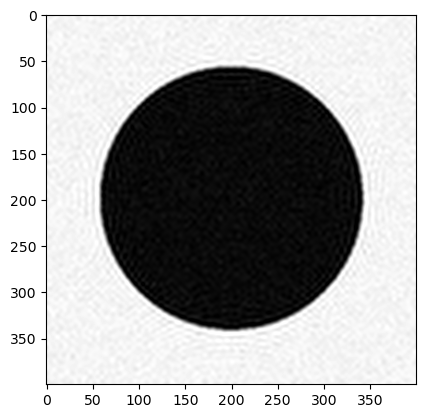

In [25]:

img = wdenoise2_py(noised_circle, 'db37')
plt.imshow(img, cmap='gray')

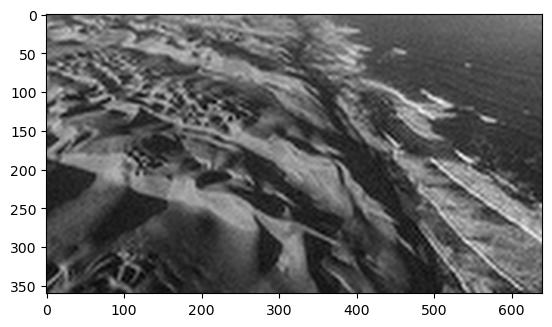

In [27]:
img = np.mean(noised_namib, -1)
img = wdenoise2_py(img, wavelet='coif15')
plt.imshow(img, cmap='gray')